## MondoSubsetOverlaps

Determine the overlaps between Mondo subsets and the overall "rare" subset. 
Use Mondo release version v2025-04-01.

The "rare" subset includes classes that have this annotation `http://purl.obolibrary.org/obo/mondo#rare` and the count of this subset is from the query `$(SPARQLDIR)/reports/COUNT-rare_subsets.sparql`/

The other subsets of interest are: 
- cancer and count is from the query `$(SPARQLDIR)/reports/COUNT-human-cancer-diseases.sparql`
- infectious disease and count is from the query `$(SPARQLDIR)/reports/COUNT-human_diseases_infectious.sparql`
- mendelian and the count is from the query `$(SPARQLDIR)/reports/COUNT-human-genetic-diseases.sparql`


In [1]:
# Imports
import pandas as pd
import numpy as np
#!pip install upsetplot

pd.set_option('display.max_colwidth', None)

In [2]:
# Get v2025-04-01 release version of Mondo

#!wget -O mondo.owl https://github.com/monarch-initiative/mondo/releases/download/v2025-04-01/mondo.owl

## Get data

In [3]:
# Get all rare disease CURIES

!robot query --input mondo.owl --query ../../sparql/reports/get_rare_disease_curies.sparql rare_diseases.tsv

In [4]:
rare_df = pd.read_csv('rare_diseases.tsv', sep='\t')
display(rare_df.head())

display(rare_df.nunique())

,?curie,?label
0,MONDO:0000005,"alopecia, isolated"
1,MONDO:0000009,"inherited bleeding disorder, platelet-type"
2,MONDO:0000014,"colorblindness, partial"
3,MONDO:0000015,classic complement early component deficiency
4,MONDO:0000023,infantile liver failure


?curie    15679
?label    15679
dtype: int64

In [5]:
# Get all cancer disease CURIEs

!robot query --input mondo.owl --query ../../sparql/reports/get_human_cancer_disease_curies.sparql human_cancer_diseases.tsv

In [6]:
human_cancer_df = pd.read_csv('human_cancer_diseases.tsv', sep='\t')
display(human_cancer_df.head())

display(human_cancer_df.nunique())

,?curie,?label
0,MONDO:0000141,mosaic variegated aneuploidy syndrome
1,MONDO:0000147,polyposis
2,MONDO:0000371,oral cavity carcinoma in situ
3,MONDO:0000372,pharynx carcinoma in situ
4,MONDO:0000373,gall bladder carcinoma in situ


?curie    4711
?label    4711
dtype: int64

In [7]:
# Get all infectious disease CURIEs

!robot query --input mondo.owl --query ../../sparql/reports/get_human_infectious_disease_curies.sparql human_infectious_diseases.tsv

In [8]:
human_infectious_df = pd.read_csv('human_infectious_diseases.tsv', sep='\t')
display(human_infectious_df.head())

display(human_infectious_df.nunique())

,?curie,?label
0,MONDO:0000222,seminal vesicle acute gonorrhea
1,MONDO:0000225,human monocytic ehrlichiosis
2,MONDO:0000227,African tick-bite fever
3,MONDO:0000229,Indian tick typhus
4,MONDO:0000230,Israeli tick typhus


?curie    1074
?label    1074
dtype: int64

In [9]:
# Get all mendelian disease CURIEs

!robot query --input mondo.owl --query ../../sparql/reports/get_human_mendelian_disease_curies.sparql human_mendelian_diseases.tsv

In [10]:
human_mendelian_df = pd.read_csv('human_mendelian_diseases.tsv', sep='\t')
display(human_mendelian_df.head())

display(human_mendelian_df.nunique())


,?curie,?label
0,MONDO:0000005,"alopecia, isolated"
1,MONDO:0000009,"inherited bleeding disorder, platelet-type"
2,MONDO:0000015,classic complement early component deficiency
3,MONDO:0000023,infantile liver failure
4,MONDO:0000030,sleep-related hypermotor epilepsy


?curie    11517
?label    11517
dtype: int64

## Find the Overlaps and Plot

In [11]:
# Find all the overlaps and get the counts 

set_mendelian = set(human_mendelian_df['?curie'].dropna())
set_infectious = set(human_infectious_df['?curie'].dropna())
set_cancer     = set(human_cancer_df['?curie'].dropna())
set_rare       = set(rare_df['?curie'].dropna())


In [12]:
# Terms common to all 4 sets
common_all = set_mendelian & set_infectious & set_cancer & set_rare

# Mendelian and Rare
mendelian_rare_only = (set_mendelian & set_rare) - (set_infectious | set_cancer)
print(f"Number of terms in mendelian_rare_only: {len(mendelian_rare_only)}")


# Mendelian and Cancer
mendelian_cancer_only = (set_mendelian & set_cancer) - (set_infectious | set_rare)
print(f"Number of terms in mendelian_cancer_only: {len(mendelian_cancer_only)}")


# Mendelian and Cancer and Rare
mendelian_cancer_rare_only = (set_mendelian & set_cancer & set_rare) - (set_infectious)
print(f"Number of terms in mendelian_cancer_rare_only: {len(mendelian_cancer_rare_only)}")


# Cancer and Rare
cancer_rare_only = (set_cancer & set_rare) - (set_infectious | set_mendelian)
print(f"Number of terms in cancer_rare_only: {len(cancer_rare_only)}")


# Infectious and Rare
infectious_rare_only = (set_infectious & set_rare) - (set_cancer | set_mendelian)
print(f"Number of terms in infectious_rare_only: {len(infectious_rare_only)}")

Number of terms in mendelian_rare_only: 8911
Number of terms in mendelian_cancer_only: 6
Number of terms in mendelian_cancer_rare_only: 549
Number of terms in cancer_rare_only: 2422
Number of terms in infectious_rare_only: 507


<Figure size 1400x1200 with 0 Axes>

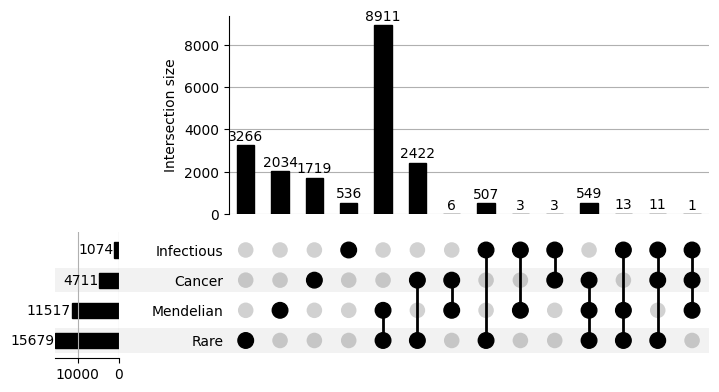

In [14]:
from upsetplot import UpSet, from_memberships, plot
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get all unique MONDO terms
all_curie_values = set_mendelian | set_infectious | set_cancer | set_rare

# Build membership tuples
memberships = []
for curie in all_curie_values:
    member = []
    if curie in set_mendelian:
        member.append('Mendelian')
    if curie in set_infectious:
        member.append('Infectious')
    if curie in set_cancer:
        member.append('Cancer')
    if curie in set_rare:
        member.append('Rare')
    memberships.append(tuple(member))

# Count each membership
membership_series = pd.Series(memberships).value_counts()

# Create UpSet-compatible data
data = from_memberships(membership_series.index, data=membership_series.values)

# Plot
plt.figure(figsize=(14, 12))
UpSet(data, show_counts=True, show_percentages=False).plot()

# Customize the plot after it’s built
plt.xticks(rotation=45, ha='right', fontsize=10)

# Save the figure
output_path = "upsetplot_disease_overlap.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# plt.title("UpSet Plot of MONDO Terms Across Disease Categories")
plt.show()
